**Predicting Bounding Boxes**

The transfer-learned model tries to predict the bouding boxes of car number plates

Author: Venkatesan Krishnamurthy

**Loading the essential libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Input, Flatten, Dropout, GlobalAveragePooling2D, Lambda
from tensorflow.keras.activations import relu
from tensorflow.keras import backend as K
import os
import pickle
from bs4 import  BeautifulSoup
import re
import cv2
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!unzip '/content/drive/MyDrive/Bounding_Boxes/archive.zip' -d '/content/drive/MyDrive/Bounding_Boxes'

**Loading and Preparing the Data**

In [4]:
# Path for the annotations(bounding boxes) and images
annotations_path = "/content/drive/MyDrive/Bounding_Boxes/annotations/"
images_path = "/content/drive/MyDrive/Bounding_Boxes/images/"

In [5]:
def get_bounding_box(xml_folder_path):
  """
  When the directory of the xml files are given, this function extracts the bounding boxes from all the files
  and returns an array of (n, 4)
  """
  bb_list = []
  for xml_file in sorted(os.listdir(path=xml_folder_path)):

    with open(xml_folder_path+xml_file, 'r') as f:
      data = f.read()

    bs_data = BeautifulSoup(data, "xml")

    xmin = str(bs_data.find('xmin'))
    xmin = int(re.findall("\d+", xmin)[0])
    ymin = str(bs_data.find('ymin'))
    ymin = int(re.findall("\d+", ymin)[0])
    xmax = str(bs_data.find('xmax'))
    xmax = int(re.findall("\d+", xmax)[0])
    ymax = str(bs_data.find('ymax'))
    ymax = int(re.findall("\d+", ymax)[0])

    bb_list.append([xmin, ymin, xmax, ymax])
  return np.array(bb_list)  

In [6]:
# The unscaled bounding boxes
Y_unscaled = get_bounding_box(annotations_path)

In [7]:
# Read in all the images. Each image is of different size. Hence storing as a list
image_list = []

for file_name in sorted(os.listdir(images_path)):                                                          
  image = tf.keras.preprocessing.image.load_img( images_path + file_name, color_mode='rgb', interpolation='nearest')
  image_list.append(tf.keras.preprocessing.image.img_to_array(image))

len(image_list)

433

In [8]:
def normalize_image_bbox(image, bbox):
  """
  Given an image and its bounding box, we resize the image to 224 x 224 x 3,
  normalize the pixels between 0-1 and also normalize the bounding boxes
  Returns the normalized image (224,224,3) and normalized bounding box list
  of len 4
  """
  factor_x = image.shape[1]
  factor_y = image.shape[0]

  img = tf.image.resize(image, (224, 224)).numpy()

  img = img/255.0

  bbox_list = [bbox[0] / factor_x , 
                 bbox[1] / factor_y, 
                 bbox[2] / factor_x , 
                 bbox[3] / factor_y]
    
  return img, bbox_list

def unnormalize_bbox(unscaled_image, scaled_bbox):
  """
  Given the original image (before normalizing), the function returns the list
  of bounding boxes in the same scale as original image. Used for converting
  the predicted bounding boxes to original scale
  """
  factor_x = unscaled_image.shape[1]
  factor_y = unscaled_image.shape[0]

  bbox_list = [scaled_bbox[0] * factor_x , 
               scaled_bbox[1] * factor_y, 
               scaled_bbox[2] * factor_x, 
               scaled_bbox[3] * factor_y]
  return unscaled_image, bbox_list

In [9]:
# Getting the normalized image array of shape (n, 224, 224, 3) and normalized 
# bounding box of shape (n, 4)
X_scaled = []
Y_scaled = []
for image, bbox in zip(image_list, Y_unscaled):
  scaled_image, scaled_bbox = normalize_image_bbox(image, bbox)
  X_scaled.append(scaled_image)
  Y_scaled.append(scaled_bbox)
X_scaled = np.array(X_scaled)
Y_scaled = np.array(Y_scaled)  

In [10]:
print(X_scaled.shape)
print(Y_scaled.shape)

(433, 224, 224, 3)
(433, 4)


In [11]:
def draw_bounding_box_on_image(image, bounding_box, color=(255, 0, 0), thickness=4):
    """
    Adds a bounding box to an image.

    Args:
      image: The original image
      bounding_box: bounding box in original scale. Array/List of length 4
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """
  
    image_width = image.shape[1]
    image_height = image.shape[0]
    disp = cv2.rectangle(image, (int(bounding_box[0]), int(bounding_box[1])), (int(bounding_box[2]), int(bounding_box[3])), color, thickness)
    return cv2_imshow(disp)

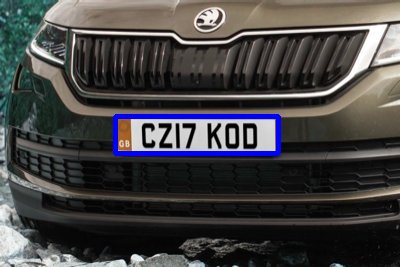

In [12]:
# Visualizing a sample image
draw_bounding_box_on_image(image_list[12], Y_unscaled[12])

In [13]:
# Getting the indices of images after shuffling. Useful while plotting with predicted bounding boxes
X_train_id, X_test_id = train_test_split(np.arange(0, len(image_list)), test_size=0.1, random_state=12, shuffle=True)

In [14]:
# The train test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.1, random_state=12, shuffle=True)

**Create, Compile and Run the Model**

In [15]:
def feature_extractor(inputs):
  # Create a mobilenet version 2 model object
  mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

  # Setting the weights of mobilenet to be non-trainable
  for layer in mobilenet_model.layers:
    layer.trainable = False
  # pass the inputs into this modle object to get a feature extractor for these inputs
  cnn_output = mobilenet_model(inputs)

  return cnn_output

def dense_layers(trained_cnn_model_output):
  # Dense layers whose weights will train on every iteration
    
  x = GlobalAveragePooling2D(name="Global_Average_Pooling")(trained_cnn_model_output)  
  x = Flatten(name = "Flatten")(x)
  x = Dense(512, "relu", name="Dense_1")(x)
  x = Dense(64, "relu", name="Dense_2")(x)
  x = Dense(4, name= "Bounding_Box")(x)
  return x 

def create_and_compile_model():
  input_layer = Input(shape=(224, 224, 3), name="input_layer")
  cnn_output = feature_extractor(input_layer)
  dense_output = dense_layers(cnn_output)

  model = Model(inputs=input_layer, outputs=dense_output, name="bounding_box_model")
  model.compile(optimizer="adam", loss="mse")
  return model

In [16]:
model = create_and_compile_model()
model.summary()

Model: "bounding_box_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
Global_Average_Pooling (Glob (None, 1280)              0         
_________________________________________________________________
Flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 512)               655872    
_________________________________________________________________
Dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
Bounding_Box (Dense)         (None, 4)          

In [ ]:
file_path = "/content/drive/MyDrive/Bounding_Boxes/model_checkpoints_2/saved-model-{epoch:02d}.h5"
callback = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, save_freq="epoch", save_weights_only=False)
history = model.fit(X_train, Y_train, batch_size=64, epochs=10, callbacks=[callback], validation_data=(X_test, Y_test), verbose=1)

In [17]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Bounding_Boxes/model_checkpoints/saved-model-32.h5")

**Prediction and Visualization of the Bounding Boxes**

In [18]:
Y_pred_scaled = model.predict(X_test)

Y_pred_unscaled = []
for idx, pred_bbox in zip(X_test_id, Y_pred_scaled):
  _ , bbox_list = unnormalize_bbox(image_list[idx], pred_bbox) # scaling the predicted bbox to original image co-ordinates
  Y_pred_unscaled.append(bbox_list)
Y_pred_unscaled = np.array(Y_pred_unscaled)

In [19]:
def draw_bounding_box_on_image_2(image, original_bbox, predicted_bbox, color1=(255, 0, 0), color2=(0, 255, 0), thickness=4):
    """
    Adds a bounding box to an image.

    Args:
      image: The original image
      original_bbox: bounding box in original scale. Array/List of length 4
      predicted_bbox: bounding box in predicted by the model. Array/List of length 4
      color1, color2: color to draw bounding box. Default is blue and green.
      thickness: line thickness. Default value is 4.
    """
  
    image_width = image.shape[1]
    image_height = image.shape[0]
    plot_original = cv2.rectangle(image, (int(original_bbox[0]), int(original_bbox[1])), (int(original_bbox[2]), int(original_bbox[3])), color1, thickness)
    plot_original_pred = cv2.rectangle(image, (int(predicted_bbox[0]), int(predicted_bbox[1])), (int(predicted_bbox[2]), int(predicted_bbox[3])), color2, thickness)

    return cv2_imshow(plot_original_pred)

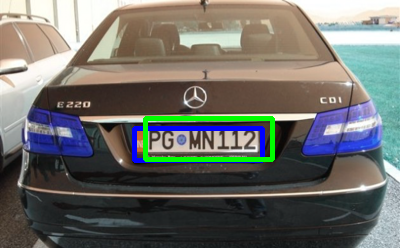

In [20]:
val = 8
draw_bounding_box_on_image_2(image_list[X_test_id[val]], Y_unscaled[X_test_id[val]], Y_pred_unscaled[val])

**Evaluate performance using IoU**

In [21]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

In [22]:
iou = intersection_over_union( Y_pred_unscaled, Y_unscaled[X_test_id])

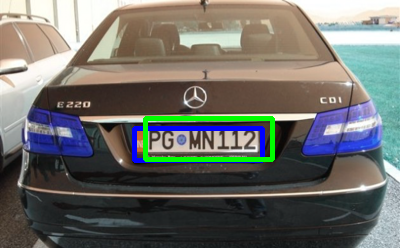

IOU Score:  0.638


In [23]:
val = 8
draw_bounding_box_on_image_2(image_list[X_test_id[val]], Y_unscaled[X_test_id[val]], Y_pred_unscaled[val])
print("IOU Score: ", round(iou[val][0],3))



---



References:


1.   Dataset: https://www.kaggle.com/andrewmvd/car-plate-detection
2.   Found this course to be helpful in gaining knowledge about Predicting Bounding Boxes: https://www.coursera.org/learn/advanced-computer-vision-with-tensorflow
